In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 10))
train_y = Variable(torch.sign(torch.cos(train_x.data * (4 * math.pi))))

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
class GPClassificationModel(gpytorch.GPModel):
    def __init__(self):
        super(GPClassificationModel,self).__init__(BernoulliLikelihood())
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
    
    
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp().expand_as(covar_x))
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

prior_model = GPClassificationModel()

In [5]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 26))
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        if plot_train_data:
            ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1)
        ax.plot(test_x.data.numpy(), pred_labels.data.numpy(), 'b')
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

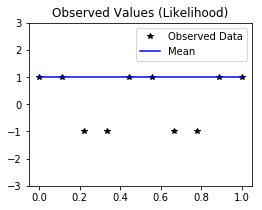

In [6]:
f = plot_model_and_predictions(prior_model, plot_train_data=True)

In [7]:
from gpytorch.inference import Inference
infer = Inference(prior_model)
posterior_model = infer.run(train_x, train_y)

# Find optimal model hyperparameters
posterior_model.train()
optimizer = optim.Adam(posterior_model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(50):
    optimizer.zero_grad()
    output = posterior_model.forward(train_x)
    loss = -posterior_model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/100 - Loss: %.3f   log_lengthscale: %.3f' % (
        i + 1, loss.data[0],
        posterior_model.prior_model.covar_module.log_lengthscale.data.squeeze()[0],
    ))
    optimizer.step()
    
# Set back to eval mode
posterior_model.eval()
None

Iter 1/100 - Loss: 1334.091   log_lengthscale: 0.000
Iter 2/100 - Loss: 1094.296   log_lengthscale: -0.100
Iter 3/100 - Loss: 685.501   log_lengthscale: -0.200
Iter 4/100 - Loss: 511.201   log_lengthscale: -0.298
Iter 5/100 - Loss: 342.716   log_lengthscale: -0.398
Iter 6/100 - Loss: 310.789   log_lengthscale: -0.498
Iter 7/100 - Loss: 145.438   log_lengthscale: -0.598
Iter 8/100 - Loss: 204.173   log_lengthscale: -0.692
Iter 9/100 - Loss: 171.146   log_lengthscale: -0.789
Iter 10/100 - Loss: 120.189   log_lengthscale: -0.888
Iter 11/100 - Loss: 215.766   log_lengthscale: -0.987
Iter 12/100 - Loss: 205.580   log_lengthscale: -1.087
Iter 13/100 - Loss: 105.772   log_lengthscale: -1.188
Iter 14/100 - Loss: 127.920   log_lengthscale: -1.287
Iter 15/100 - Loss: 121.472   log_lengthscale: -1.388
Iter 16/100 - Loss: 66.550   log_lengthscale: -1.481
Iter 17/100 - Loss: 45.466   log_lengthscale: -1.572
Iter 18/100 - Loss: 79.782   log_lengthscale: -1.657
Iter 19/100 - Loss: 47.243   log_length

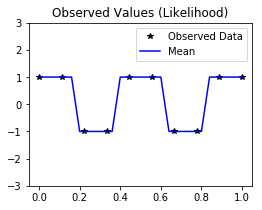

In [8]:
f = plot_model_and_predictions(posterior_model)